In [31]:
import torch
from batchgenerators.utilities.file_and_folder_operations import join
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor

# instantiate the nnUNetPredictor
predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device('mps', 0),
    verbose=False,
    verbose_preprocessing=False,
    allow_tqdm=True
)

model_folder = '/Users/yuma/Yuma-Kanematsu/nnUNet/src/results/Dataset002_ForTest_segmenetation/nnUNetTrainer__nnUNetPlans__2d'

# initializes the network architecture, loads the checkpoint
predictor.initialize_from_trained_model_folder(
    model_folder,
    use_folds=(0,),
    checkpoint_name='checkpoint_best.pth',
)
# variant 1: give input and output folders
input_folder = '/Users/yuma/Yuma-Kanematsu/nnUNet/src/raw_data/Dataset002_ForTest_segmenetation/imagesTs'
output_folder = '/Users/yuma/Yuma-Kanematsu/nnUNet/src/results/250328_inferece'
predictor.predict_from_files(input_folder,
                                output_folder,
                                save_probabilities=False, overwrite=True,
                                num_processes_preprocessing=2, num_processes_segmentation_export=2,
                                folder_with_segs_from_prev_stage=None, num_parts=1, part_id=0)

perform_everything_on_device=True is only supported for cuda devices! Setting this to False
nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_results is not defined and nnU-Net cannot be used fo

100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


sending off prediction to background worker for resampling and export
done with 6870292_16_R_FLOOR-2

Predicting 6870292_18_R_FLOOR-2:
perform_everything_on_device: False


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


sending off prediction to background worker for resampling and export
done with 6870292_18_R_FLOOR-2

Predicting 6870292_19_R_FLOOR-3:
perform_everything_on_device: False


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


sending off prediction to background worker for resampling and export
done with 6870292_19_R_FLOOR-3

Predicting 6870292_20_R_FLOOR-3:
perform_everything_on_device: False


100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


sending off prediction to background worker for resampling and export
done with 6870292_20_R_FLOOR-3

Predicting 6870292_21_R_FLOOR-3:
perform_everything_on_device: False


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


sending off prediction to background worker for resampling and export
done with 6870292_21_R_FLOOR-3

Predicting 6870292_22_R_FLOOR-3:
perform_everything_on_device: False


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


sending off prediction to background worker for resampling and export
done with 6870292_22_R_FLOOR-3

Predicting 6870292_23_R_FLOOR-3:
perform_everything_on_device: False


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


sending off prediction to background worker for resampling and export
done with 6870292_23_R_FLOOR-3


[None, None, None, None, None, None, None]

Unknown image resource 1092
Unknown key: b'CAI '
Unknown tagged block: b'CAI ', b'\x00\x00\x00\x03\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00 ... =77'
Unknown key: b'OCIO'
Unknown tagged block: b'OCIO', b'\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00\x00\x1bdo ... =170'
Unknown key: b'GenI'
Unknown tagged block: b'GenI', b'\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00\x00\x0bge ... =84'


Original image shape: (512, 512)
Predicted mask shape: (512, 512)
Predicted mask range: 0 to 1
Predicted mask unique values: [0 1]
Ground truth mask shape: (512, 512)
Ground truth mask unique values: [0 1]
Visualization saved to: /Users/yuma/Yuma-Kanematsu/nnUNet/src/raw_data/four_panel_visualization.png


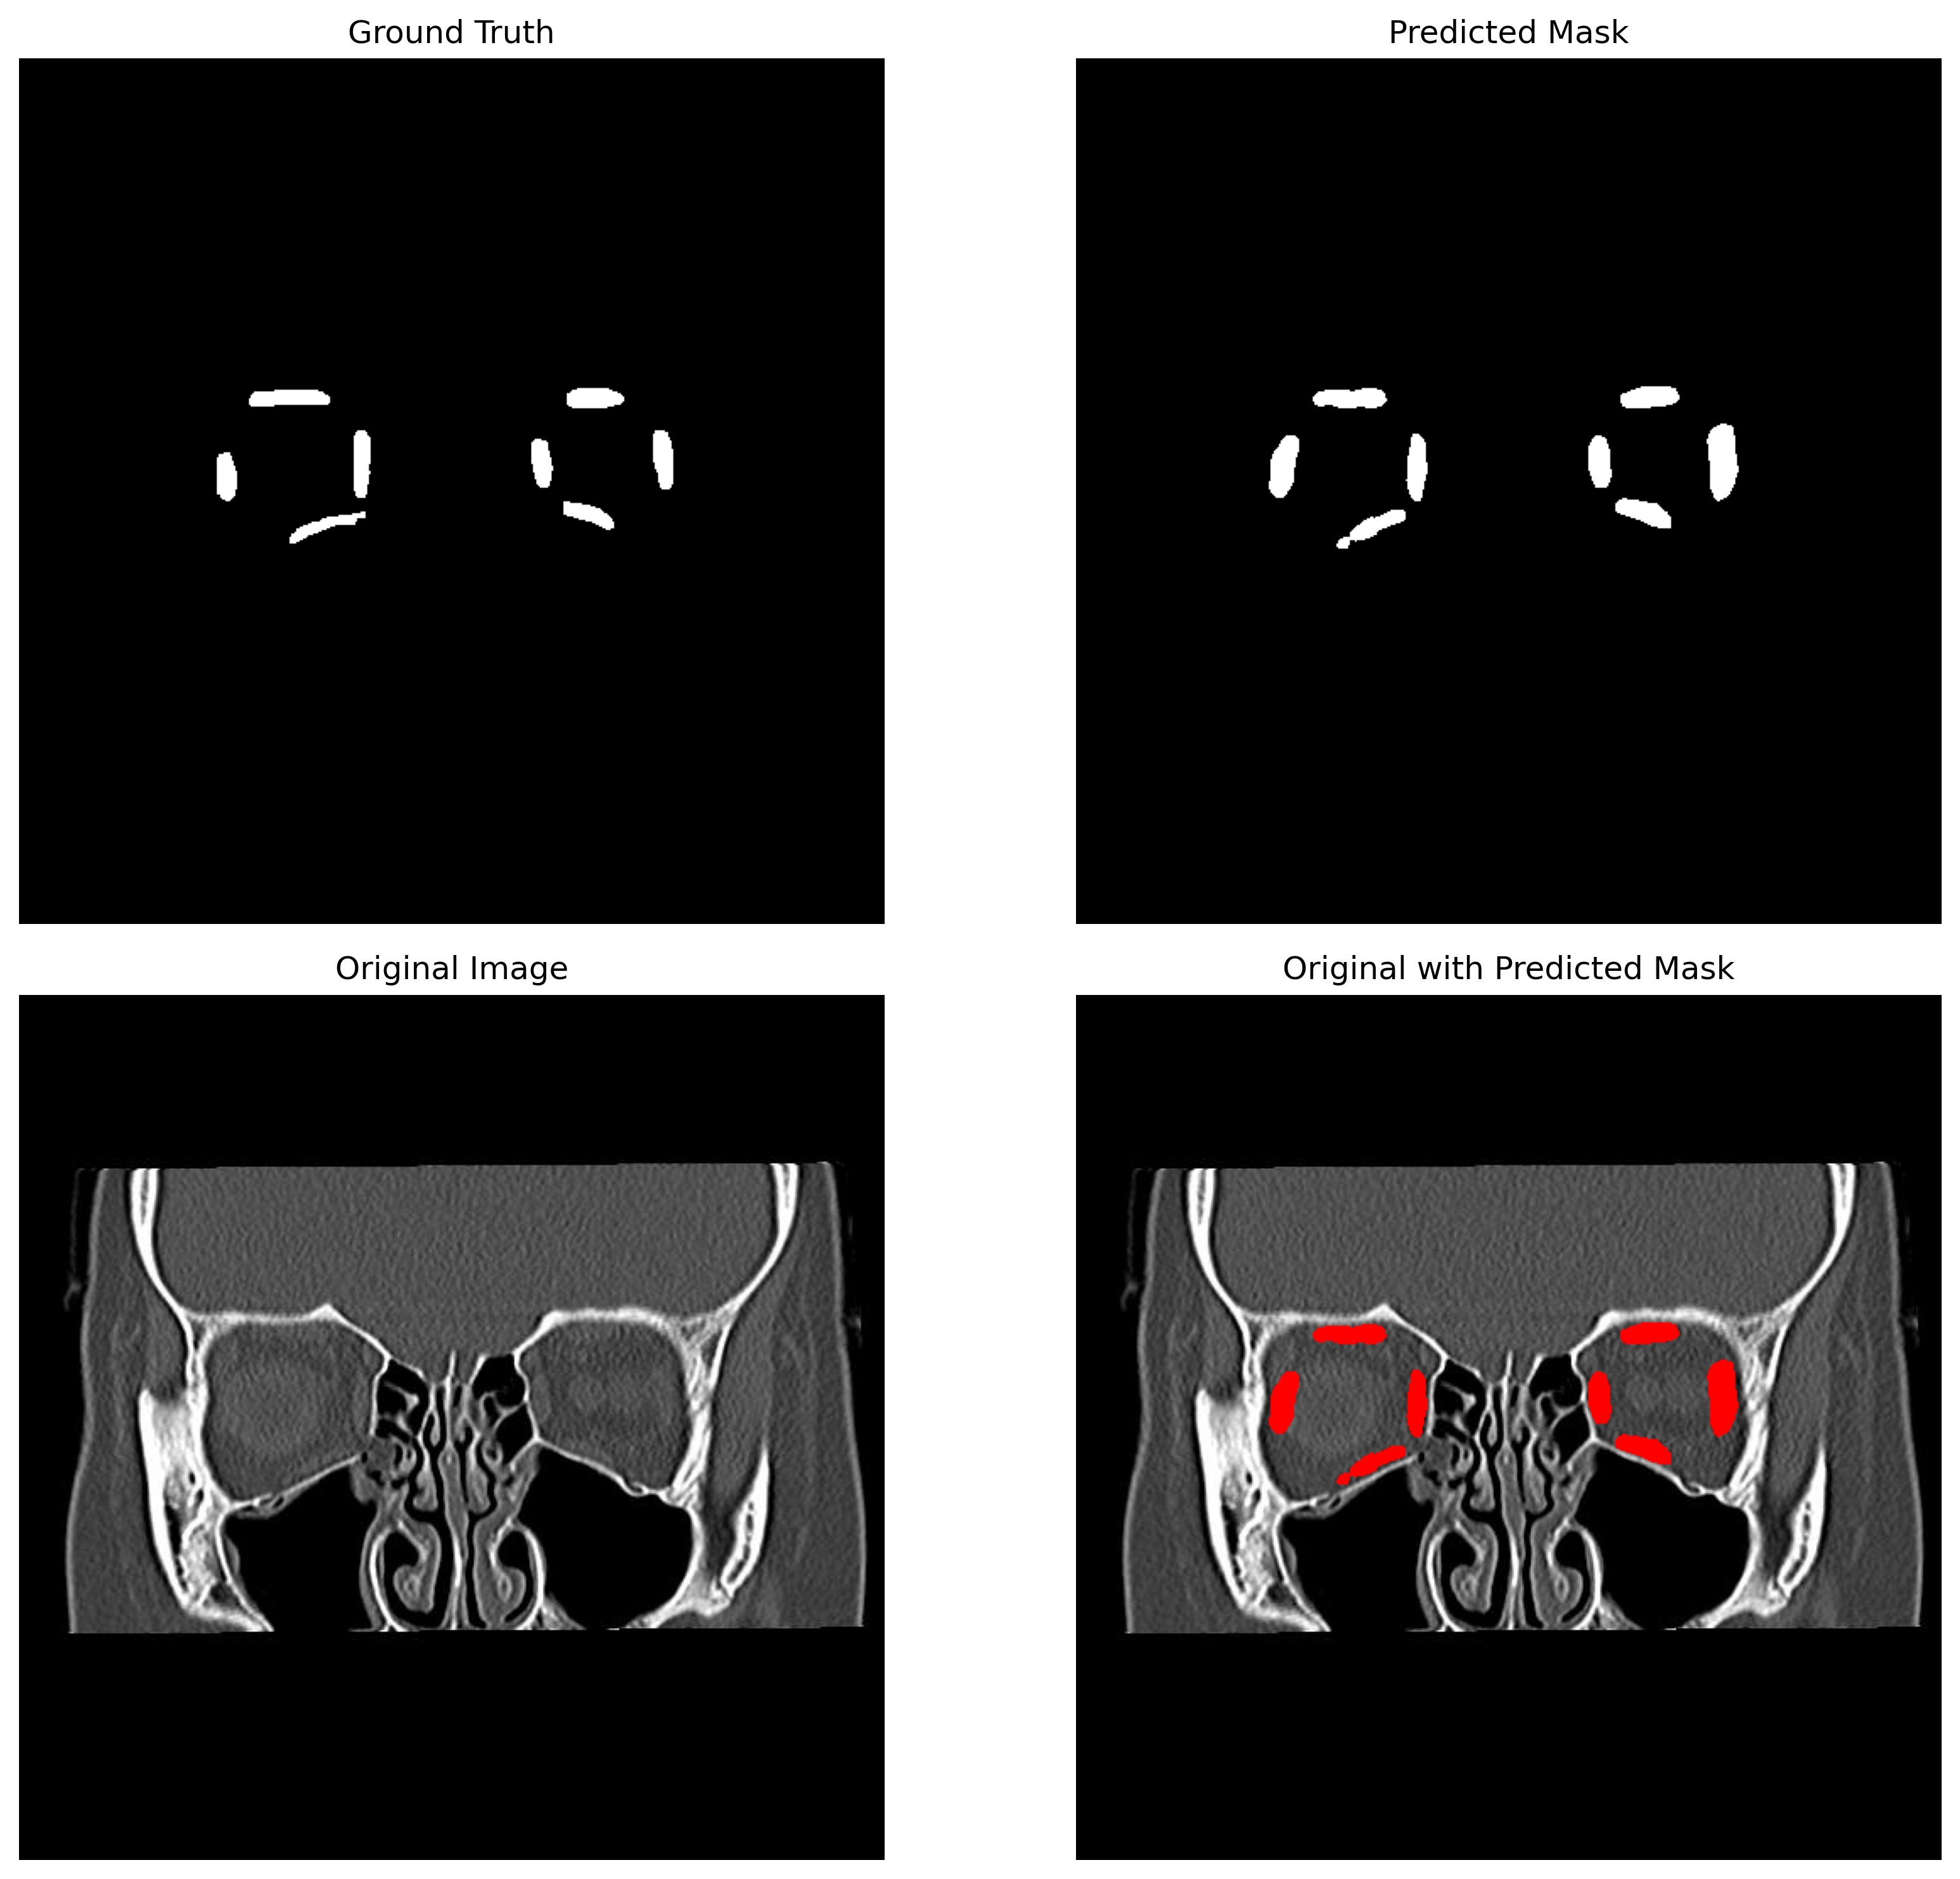

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from psd_tools import PSDImage
import os

# Configuration
# Paths
original_image_path = '/Users/yuma/Yuma-Kanematsu/nnUNet/src/raw_data/Dataset002_ForTest_segmenetation/imagesTs/6870292_16_R_FLOOR-2_0000.png'
predicted_mask_path = '/Users/yuma/Yuma-Kanematsu/nnUNet/src/results/250329_inferece/6870292_16_R_FLOOR-2.png'
ground_truth_psd_path = '/Users/yuma/Yuma-Kanematsu/nnUNet/src/raw_data/Dataset002_ForTest_segmenetation/imagesTs/6870292_16_R_FLOOR-2.psd'
output_path = '/Users/yuma/Yuma-Kanematsu/nnUNet/src/raw_data/four_panel_visualization.png'

# Parameters
color_threshold = 50  # Threshold for red channel extraction from PSD

# Function to convert PSD to red mask (from your code)
def convert_psd_to_red_mask(psd_path, color_threshold=50):
    """
    Convert PSD file to a binary mask based on red channel
    """
    try:
        # Open PSD file
        psd = PSDImage.open(psd_path)
        # Get composite image
        composite_image = psd.composite()
        # Convert to numpy array
        img_array = np.array(composite_image)
        
        # Extract red channel from RGBA array
        if len(img_array.shape) == 3 and img_array.shape[2] == 4:  # RGBA
            red_channel = img_array[:, :, 0]
            green_channel = img_array[:, :, 1]
            blue_channel = img_array[:, :, 2]
            alpha_channel = img_array[:, :, 3]
            
            # Red mask condition: high red component, low green and blue, has transparency
            red_mask = ((red_channel > green_channel + color_threshold) & 
                        (red_channel > blue_channel + color_threshold) & 
                        (alpha_channel > 0))
        elif len(img_array.shape) == 3 and img_array.shape[2] == 3:  # RGB
            red_channel = img_array[:, :, 0]
            green_channel = img_array[:, :, 1]
            blue_channel = img_array[:, :, 2]
            
            # Red mask condition
            red_mask = ((red_channel > green_channel + color_threshold) & 
                        (red_channel > blue_channel + color_threshold))
        else:
            # Grayscale or unsupported format
            print(f"Warning: Unsupported image format (shape: {img_array.shape})")
            return None
        
        # Convert to binary mask (True = 1, False = 0) - in nnU-Net, 1 is typically foreground
        binary_mask = red_mask.astype(np.uint8)
        
        return binary_mask
    except Exception as e:
        print(f"Error: Processing PSD file {psd_path} failed: {str(e)}")
        return None

# Check if all files exist
files_exist = True
for path in [original_image_path, predicted_mask_path, ground_truth_psd_path]:
    if not os.path.exists(path):
        print(f"Error: File not found: {path}")
        files_exist = False

if not files_exist:
    print("Missing required files. Cannot proceed.")
else:
    try:
        # Load original image
        original_img = Image.open(original_image_path)
        original_array = np.array(original_img)
        
        # Load predicted mask
        predicted_mask_img = Image.open(predicted_mask_path)
        predicted_mask_array = np.array(predicted_mask_img)
        
        # Create binary mask from prediction (values > 0 become 255)
        binary_predicted_mask = np.zeros_like(predicted_mask_array)
        binary_predicted_mask[predicted_mask_array > 0] = 255
        
        # Process ground truth from PSD
        ground_truth_mask = convert_psd_to_red_mask(ground_truth_psd_path, color_threshold)
        
        # If ground truth mask extraction failed, create empty mask
        if ground_truth_mask is None:
            print("Warning: Could not extract mask from PSD. Creating empty mask.")
            ground_truth_mask = np.zeros_like(binary_predicted_mask)
        
        # Scale ground truth mask to 0-255 for display
        ground_truth_display = ground_truth_mask * 255
        
        # Display information
        print(f"Original image shape: {original_array.shape}")
        print(f"Predicted mask shape: {predicted_mask_array.shape}")
        print(f"Predicted mask range: {predicted_mask_array.min()} to {predicted_mask_array.max()}")
        print(f"Predicted mask unique values: {np.unique(predicted_mask_array)}")
        print(f"Ground truth mask shape: {ground_truth_mask.shape}")
        print(f"Ground truth mask unique values: {np.unique(ground_truth_mask)}")
        
        # Create overlay image (original + predicted mask)
        # Convert original to RGB if grayscale
        if len(original_array.shape) == 2:
            original_rgb = np.stack([original_array, original_array, original_array], axis=2)
        else:
            original_rgb = original_array
            
        # Create a copy for overlay
        overlay_img = original_rgb.copy()
        
        # Apply red mask for predicted areas
        overlay_img[binary_predicted_mask > 0, 0] = 255  # Red channel
        overlay_img[binary_predicted_mask > 0, 1] = 0    # Green channel
        overlay_img[binary_predicted_mask > 0, 2] = 0    # Blue channel
        
        # Create the plot (2x2 grid)
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Ground Truth Mask
        axes[0, 0].imshow(ground_truth_display, cmap='gray')
        axes[0, 0].set_title('Ground Truth')
        axes[0, 0].axis('off')
        
        # Predicted Mask
        axes[0, 1].imshow(binary_predicted_mask, cmap='gray')
        axes[0, 1].set_title('Predicted Mask')
        axes[0, 1].axis('off')
        
        # Original Image
        axes[1, 0].imshow(original_array, cmap='gray' if len(original_array.shape) == 2 else None)
        axes[1, 0].set_title('Original Image')
        axes[1, 0].axis('off')
        
        # Overlay (Original + Predicted Mask)
        axes[1, 1].imshow(overlay_img)
        axes[1, 1].set_title('Original with Predicted Mask')
        axes[1, 1].axis('off')
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {output_path}")
        
        # Display in IPython if possible
        try:
            from IPython.display import display, Image as IPImage
            display(IPImage(output_path))
        except ImportError:
            print("IPython display not available. Please check the saved image file.")
        
    except Exception as e:
        print(f"Error occurred during visualization: {str(e)}")